In [2]:
!pip install pytorch-msssim

In [3]:
import os
import glob
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image as PILImage
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from google.colab import drive
from pytorch_msssim import SSIM
import matplotlib.pyplot as plt
import random
from IPython.display import Image, display

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define dataset paths (same as original)
local_base_path = '/content/FER'
if not os.path.exists(local_base_path):
    gdrive_base_path = '/content/drive/MyDrive/FER'
    print("📂 Copying dataset to local disk...")
    start_time = time.time()
    import shutil
    shutil.copytree(gdrive_base_path, local_base_path)
    print(f"✅ Dataset copied to {local_base_path} in {time.time() - start_time:.2f} seconds")

splits = {
    'test': os.path.join(local_base_path, 'Test')
}
sigma = 15
image_size = (48, 48)
drive_checkpoint_dir = '/content/drive/MyDrive/bimsaae_checkpoints'

📂 Copying dataset to local disk...
✅ Dataset copied to /content/FER in 605.90 seconds


In [6]:
# Verify test folder
test_path = splits['test']
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Test folder not found: {test_path}")
noisy_path = os.path.join(test_path, f'noisy_sigma{sigma}')
if not os.path.exists(noisy_path):
    raise FileNotFoundError(f"Noisy folder not found: {noisy_path}")
print(f"📂 Found test folder: {test_path}")

📂 Found test folder: /content/FER/Test


In [7]:
# Dataset class (same as original)
class PairedNoisyCleanDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        self.transform = transform
        split_dir = os.path.join(base_dir, split.capitalize())
        noisy_dir = os.path.join(split_dir, f'noisy_sigma{sigma}')
        self.clean_images = []
        for root, _, files in os.walk(split_dir):
            if os.path.abspath(root) == os.path.abspath(noisy_dir):
                continue
            for f in files:
                if f.lower().endswith('.jpg'):
                    self.clean_images.append(os.path.join(root, f))
        self.noisy_images = [
            os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir)
            if f.lower().endswith('.jpg')
        ]
        clean_dict = {os.path.basename(p): p for p in self.clean_images}
        noisy_dict = {os.path.basename(p): p for p in self.noisy_images}
        self.matched_clean = []
        self.matched_noisy = []
        for fname in noisy_dict:
            if fname in clean_dict:
                self.matched_clean.append(clean_dict[fname])
                self.matched_noisy.append(noisy_dict[fname])
        print(f"📊 [test] Found {len(self.matched_clean)} paired samples")

    def __len__(self):
        return len(self.matched_clean)

    def __getitem__(self, idx):
        noisy_img = PILImage.open(self.matched_noisy[idx]).convert('L')
        clean_img = PILImage.open(self.matched_clean[idx]).convert('L')
        if self.transform:
            seed = torch.randint(0, 2**31, (1,)).item()
            torch.manual_seed(seed)
            noisy_img = self.transform(noisy_img)
            torch.manual_seed(seed)
            clean_img = self.transform(clean_img)
        return noisy_img, clean_img, self.matched_noisy[idx]

In [8]:
# Transforms (same as original)
val_test_transform = transforms.ToTensor()

# Test Dataset and DataLoader
batch_size = 16
test_dataset = PairedNoisyCleanDataset(local_base_path, 'test', val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
print(f"Test dataset size: {len(test_dataset)}")

📊 [test] Found 2148 paired samples
Test dataset size: 2148


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
# Model definition (same as original)
class MultiScaleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(1, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(1, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True)
        )
        self.residual = nn.Conv2d(1, 252, kernel_size=1)

    def forward(self, x):
        f1 = self.branch3x3(x)
        f2 = self.branch5x5(x)
        res = self.residual(x)
        return torch.cat([f1, f2], dim=1) + res

class NoiseGateModule(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mask = self.conv(x)
        mask = self.sigmoid(mask)
        return x * mask

class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.avg_pool(x)
        max_out = self.max_pool(x)
        pooled = torch.cat([avg_out, max_out], dim=1)
        attn = self.conv(pooled)
        attn = self.sigmoid(attn)
        return x * attn

class DualHeadDecoder(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.structural_head = nn.Sequential(
            nn.Conv2d(in_channels, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 63, kernel_size=3, padding=1),
            nn.BatchNorm2d(63),
            nn.ReLU(inplace=True),
            nn.Conv2d(63, 33, kernel_size=3, padding=1),
            nn.BatchNorm2d(33),
            nn.ReLU(inplace=True),
            nn.Conv2d(33, 15, kernel_size=3, padding=1),
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )
        self.texture_head = nn.Sequential(
            nn.Conv2d(in_channels, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 63, kernel_size=5, padding=2),
            nn.BatchNorm2d(63),
            nn.ReLU(inplace=True),
            nn.Conv2d(63, 33, kernel_size=5, padding=2),
            nn.BatchNorm2d(33),
            nn.ReLU(inplace=True),
            nn.Conv2d(33, 15, kernel_size=5, padding=2),
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 1, kernel_size=5, padding=2),
            nn.BatchNorm2d(1)
        )
        self.alpha = nn.Parameter(torch.tensor(0.6))

    def forward(self, x):
        struct = self.structural_head(x)
        text = self.texture_head(x)
        return self.alpha * struct + (1 - self.alpha) * text

class SharpeningModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        laplacian = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]], dtype=torch.float32)
        self.conv.weight = nn.Parameter(laplacian)
        self.strength = nn.Parameter(torch.tensor(0.7))

    def forward(self, x):
        edges = self.conv(x)
        return x + self.strength * edges

class BiMSAAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MultiScaleEncoder()
        self.noise_gate = NoiseGateModule()
        self.attention = ChannelAttentionBlock()
        self.decoder = DualHeadDecoder()
        self.sharpen = SharpeningModule()
        self.skip_conv = nn.Conv2d(252, 252, kernel_size=1)

    def forward(self, x):
        f = self.encoder(x)
        skip = self.skip_conv(f)
        f = self.noise_gate(f)
        f = self.attention(f)
        f = f + skip
        out = self.decoder(f)
        out = torch.sigmoid(out)
        out = self.sharpen(out)
        return torch.clamp(out, 0, 1)

In [10]:
# Loss Functions (only needed for loss computation if desired)
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:9].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(dtype=torch.float32)
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        output = output.repeat(1, 3, 1, 1).to(dtype=torch.float32)
        target = target.repeat(1, 3, 1, 1).to(dtype=torch.float32)
        output_vgg = self.vgg(output)
        target_vgg = self.vgg(target)
        return self.mse(output_vgg, target_vgg)

class EdgeLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.sobel_x = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], dtype=torch.float32)
        self.sobel_y = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], dtype=torch.float32)
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        self.sobel_x = self.sobel_x.to(output.device)
        self.sobel_y = self.sobel_y.to(output.device)
        grad_x_out = F.conv2d(output, self.sobel_x)
        grad_y_out = F.conv2d(output, self.sobel_y)
        grad_x_tgt = F.conv2d(target, self.sobel_x)
        grad_y_tgt = F.conv2d(target, self.sobel_y)
        return self.mse(grad_x_out, grad_x_tgt) + self.mse(grad_y_out, grad_y_tgt)

In [11]:
# Device and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiMSAAE().to(device)
mse_criterion = nn.MSELoss()
perceptual_criterion = PerceptualLoss().to(device)
ssim_criterion = SSIM(data_range=1.0, channel=1, win_size=7).to(device)
edge_criterion = EdgeLoss().to(device)

# Load the saved model (use the final model or best)
final_model_path = os.path.join(drive_checkpoint_dir, 'bimsaae_final.pth')
if os.path.exists(final_model_path):
    model.load_state_dict(torch.load(final_model_path, map_location=device))
    print(f"✅ Loaded model from {final_model_path}")
else:
    # Fallback to best
    best_model_path = os.path.join(drive_checkpoint_dir, 'bimsaae_best.pth')
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"✅ Loaded best model from {best_model_path}")
    else:
        raise FileNotFoundError(f"No model found in {drive_checkpoint_dir}")

model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 103MB/s] 


✅ Loaded model from /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_final.pth


BiMSAAE(
  (encoder): MultiScaleEncoder(
    (branch3x3): Sequential(
      (0): Conv2d(1, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(126, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (branch5x5): Sequential(
      (0): Conv2d(1, 126, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(126, 126, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (residual): Conv2d(1, 252, kernel_size=(1, 1), stride=(1, 1))
  )
  (noise_gate): Noi

In [12]:
# Aggregate evaluation on entire test set
print("\n🔍 Evaluating on entire test set...")
test_psnr_clean_denoised = 0.0
test_ssim_clean_denoised = 0.0
total_samples = 0
test_loss = 0.0
inference_times = []

with torch.no_grad():
    for noisy, clean, _ in test_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        start_time = time.time()
        denoised = model(noisy)
        inf_time = (time.time() - start_time) * 1000 / noisy.size(0)  # ms per image
        inference_times.append(inf_time)

        # Compute loss (optional)
        mse_loss = mse_criterion(denoised, clean)
        perceptual_loss = perceptual_criterion(denoised, clean)
        ssim_loss = 1 - ssim_criterion(denoised, clean)
        edge_loss = edge_criterion(denoised, clean)
        loss = 0.5 * mse_loss + 0.3 * perceptual_loss + 0.1 * ssim_loss + 0.1 * edge_loss
        test_loss += loss.item() * noisy.size(0)

        # Compute PSNR and SSIM (clean vs denoised)
        clean_np = clean.cpu().numpy()
        denoised_np = denoised.cpu().numpy()
        for i in range(noisy.size(0)):
            psnr_cd = peak_signal_noise_ratio(clean_np[i, 0], denoised_np[i, 0], data_range=1.0)
            ssim_cd = structural_similarity(clean_np[i, 0], denoised_np[i, 0], data_range=1.0, win_size=7)
            test_psnr_clean_denoised += psnr_cd
            test_ssim_clean_denoised += ssim_cd
            total_samples += 1

test_loss /= len(test_dataset)
test_psnr_clean_denoised /= total_samples
test_ssim_clean_denoised /= total_samples
avg_inf_time = sum(inference_times) / len(inference_times) if inference_times else 0

print(f"📊 Aggregate Test Results ({total_samples} samples):")
print(f"  Loss: {test_loss:.6f}")
print(f"  Average Inference Time: {avg_inf_time:.2f} ms/image")
print(f"  Average PSNR (Clean vs Denoised): {test_psnr_clean_denoised:.2f} dB")
print(f"  Average SSIM (Clean vs Denoised): {test_ssim_clean_denoised:.4f}")


🔍 Evaluating on entire test set...
📊 Aggregate Test Results (2148 samples):
  Loss: 0.078497
  Average Inference Time: 2.18 ms/image
  Average PSNR (Clean vs Denoised): 28.57 dB
  Average SSIM (Clean vs Denoised): 0.9243


In [13]:
# Sample evaluation for 10 random images
num_samples = 10
output_dir = '/content/drive/MyDrive/denoising_samples_eval'
os.makedirs(output_dir, exist_ok=True)

print(f"\n🎲 Generating samples for {num_samples} random images...")
with torch.no_grad():
    test_samples = random.sample(list(test_dataset), min(num_samples, len(test_dataset)))
    sample_psnr_clean_denoised = []
    sample_ssim_clean_denoised = []
    for idx, (noisy, clean, noisy_path) in enumerate(test_samples):
        noisy, clean = noisy.unsqueeze(0).to(device), clean.unsqueeze(0).to(device)
        denoised = model(noisy)

        # Convert to numpy
        noisy_np = np.clip(noisy.cpu().numpy()[0, 0], 0, 1).astype(np.float32)
        clean_np = np.clip(clean.cpu().numpy()[0, 0], 0, 1).astype(np.float32)
        denoised_np = np.clip(denoised.cpu().numpy()[0, 0], 0, 1).astype(np.float32)

        # Metrics (clean vs denoised)
        psnr_cd = peak_signal_noise_ratio(clean_np, denoised_np, data_range=1.0)
        ssim_cd = structural_similarity(clean_np, denoised_np, data_range=1.0, win_size=7)
        sample_psnr_clean_denoised.append(psnr_cd)
        sample_ssim_clean_denoised.append(ssim_cd)

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))
        axes[0].imshow(clean_np, cmap='gray')
        axes[0].set_title('Clean')
        axes[0].axis('off')
        axes[1].imshow(noisy_np, cmap='gray')
        axes[1].set_title('Noisy')
        axes[1].axis('off')
        axes[2].imshow(denoised_np, cmap='gray')
        axes[2].set_title(f'Denoised\nPSNR: {psnr_cd:.2f} dB\nSSIM: {ssim_cd:.4f}')
        axes[2].axis('off')
        plt.tight_layout()

        # Save plot
        sample_path = os.path.join(output_dir, f'eval_sample_{idx+1}_{os.path.basename(noisy_path)}')
        plt.savefig(sample_path, dpi=150, bbox_inches='tight')
        plt.close(fig)

        print(f"✅ Sample {idx+1} saved: {sample_path}.png")
        print(f"  PSNR (Clean-Denoised): {psnr_cd:.2f} dB | SSIM: {ssim_cd:.4f}")

# Print sample aggregates
print(f"\n📊 Sample Aggregates ({num_samples} random samples):")
print(f"  Average PSNR (Clean vs Denoised): {np.mean(sample_psnr_clean_denoised):.2f} dB")
print(f"  Average SSIM (Clean vs Denoised): {np.mean(sample_ssim_clean_denoised):.4f}")
print(f"📸 All sample plots saved to {output_dir}")


🎲 Generating samples for 10 random images...
✅ Sample 1 saved: /content/drive/MyDrive/denoising_samples_eval/eval_sample_1_PublicTest_89904184.jpg.png
  PSNR (Clean-Denoised): 28.62 dB | SSIM: 0.9440
✅ Sample 2 saved: /content/drive/MyDrive/denoising_samples_eval/eval_sample_2_PublicTest_59161828.jpg.png
  PSNR (Clean-Denoised): 26.69 dB | SSIM: 0.9410
✅ Sample 3 saved: /content/drive/MyDrive/denoising_samples_eval/eval_sample_3_PublicTest_95508061.jpg.png
  PSNR (Clean-Denoised): 26.96 dB | SSIM: 0.9474
✅ Sample 4 saved: /content/drive/MyDrive/denoising_samples_eval/eval_sample_4_PublicTest_17904919.jpg.png
  PSNR (Clean-Denoised): 28.11 dB | SSIM: 0.9329
✅ Sample 5 saved: /content/drive/MyDrive/denoising_samples_eval/eval_sample_5_PublicTest_16904324.jpg.png
  PSNR (Clean-Denoised): 30.83 dB | SSIM: 0.9115
✅ Sample 6 saved: /content/drive/MyDrive/denoising_samples_eval/eval_sample_6_PublicTest_29922615.jpg.png
  PSNR (Clean-Denoised): 29.48 dB | SSIM: 0.9368
✅ Sample 7 saved: /conte


🎲 Generating 10 random samples (Clean + Noisy + Denoised with metrics)...


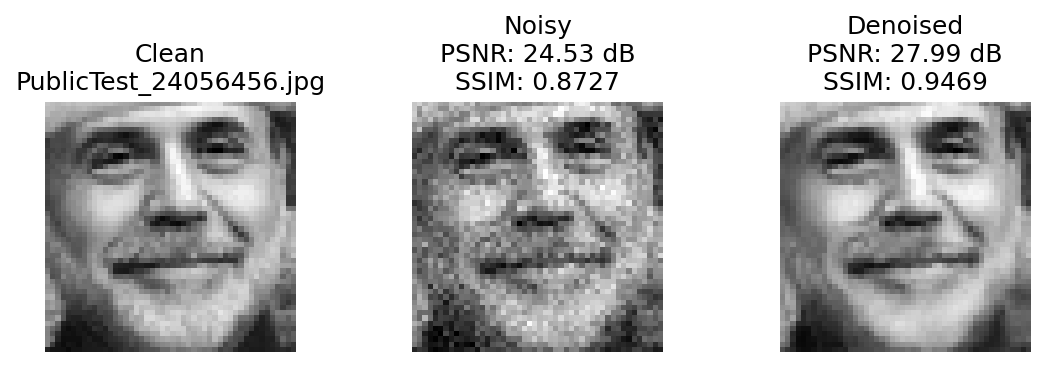

✅ Sample 1 displayed and saved: /content/drive/MyDrive/denoising_samples_eval/sample_1_PublicTest_24056456.jpg.png
  Clean-Noisy: PSNR: 24.53 dB | SSIM: 0.8727
  Clean-Denoised: PSNR: 27.99 dB | SSIM: 0.9469


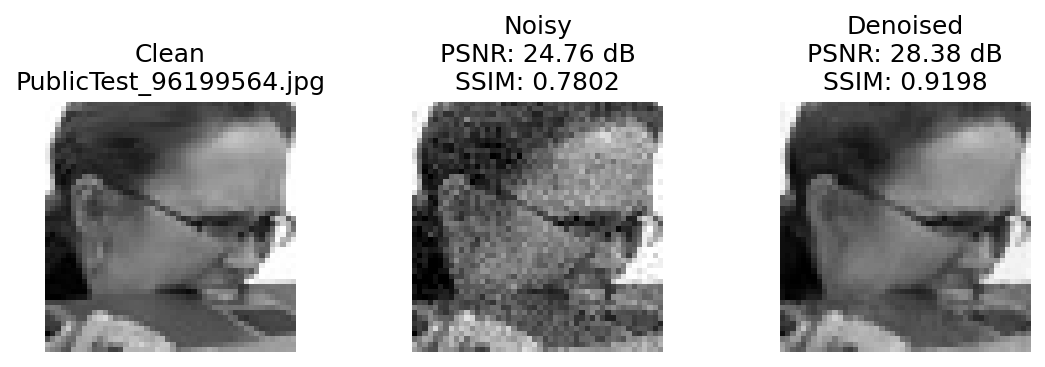

✅ Sample 2 displayed and saved: /content/drive/MyDrive/denoising_samples_eval/sample_2_PublicTest_96199564.jpg.png
  Clean-Noisy: PSNR: 24.76 dB | SSIM: 0.7802
  Clean-Denoised: PSNR: 28.38 dB | SSIM: 0.9198


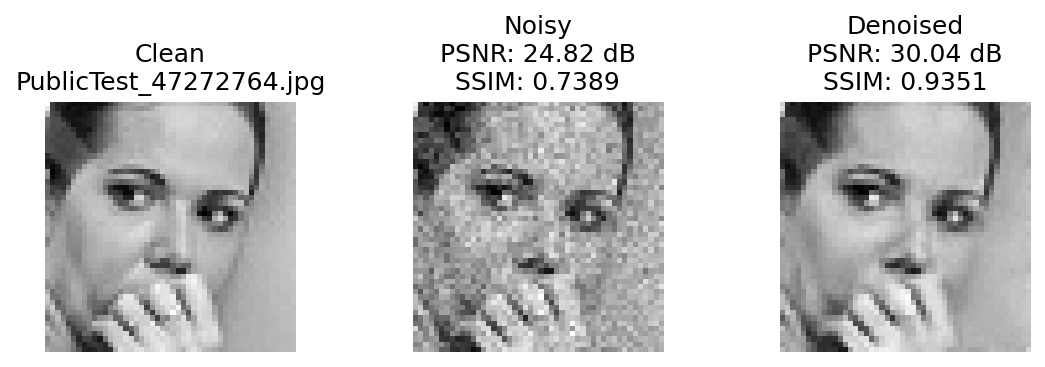

✅ Sample 3 displayed and saved: /content/drive/MyDrive/denoising_samples_eval/sample_3_PublicTest_47272764.jpg.png
  Clean-Noisy: PSNR: 24.82 dB | SSIM: 0.7389
  Clean-Denoised: PSNR: 30.04 dB | SSIM: 0.9351


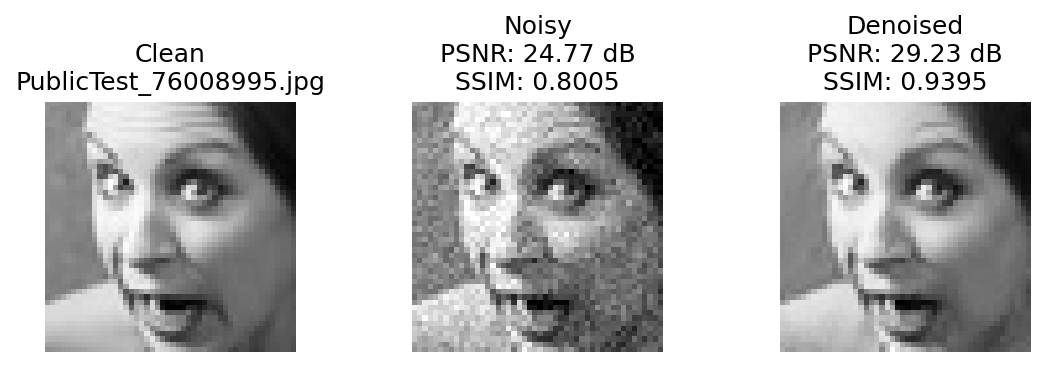

✅ Sample 4 displayed and saved: /content/drive/MyDrive/denoising_samples_eval/sample_4_PublicTest_76008995.jpg.png
  Clean-Noisy: PSNR: 24.77 dB | SSIM: 0.8005
  Clean-Denoised: PSNR: 29.23 dB | SSIM: 0.9395


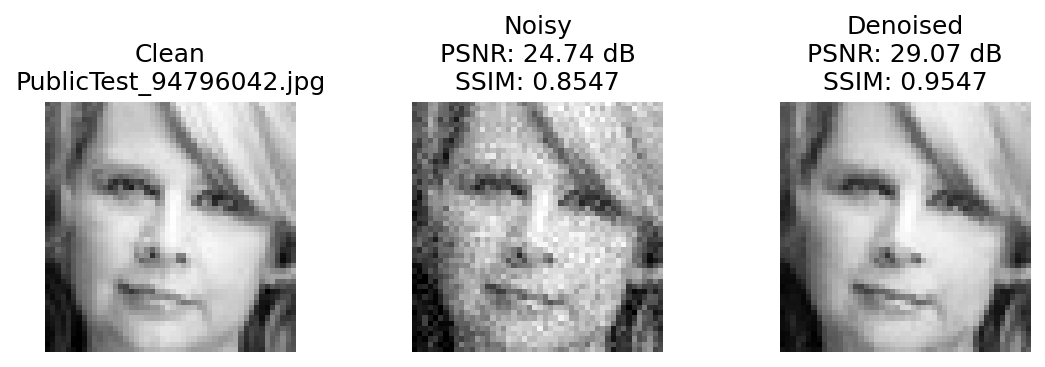

✅ Sample 5 displayed and saved: /content/drive/MyDrive/denoising_samples_eval/sample_5_PublicTest_94796042.jpg.png
  Clean-Noisy: PSNR: 24.74 dB | SSIM: 0.8547
  Clean-Denoised: PSNR: 29.07 dB | SSIM: 0.9547


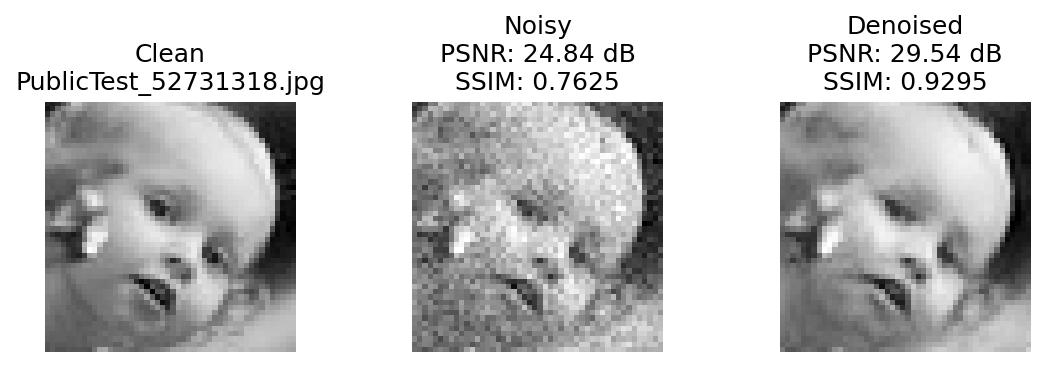

✅ Sample 6 displayed and saved: /content/drive/MyDrive/denoising_samples_eval/sample_6_PublicTest_52731318.jpg.png
  Clean-Noisy: PSNR: 24.84 dB | SSIM: 0.7625
  Clean-Denoised: PSNR: 29.54 dB | SSIM: 0.9295


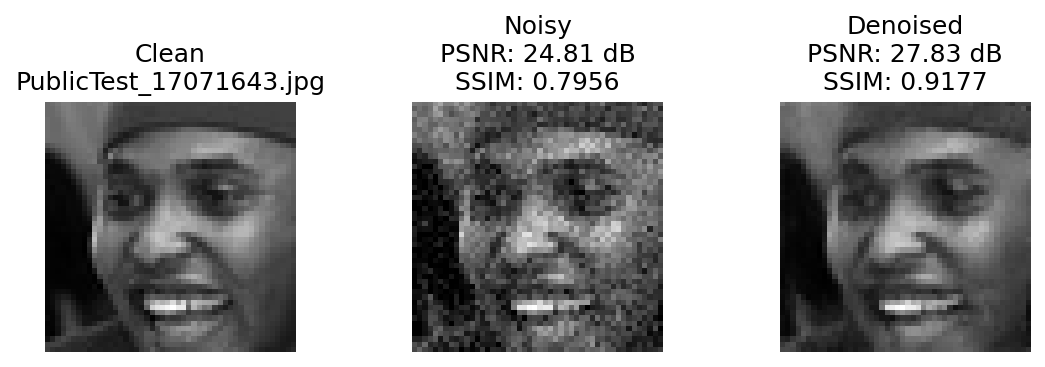

✅ Sample 7 displayed and saved: /content/drive/MyDrive/denoising_samples_eval/sample_7_PublicTest_17071643.jpg.png
  Clean-Noisy: PSNR: 24.81 dB | SSIM: 0.7956
  Clean-Denoised: PSNR: 27.83 dB | SSIM: 0.9177


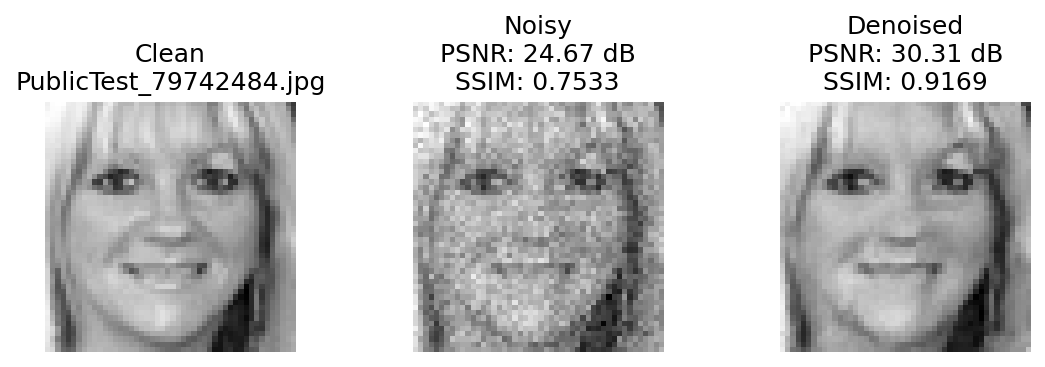

✅ Sample 8 displayed and saved: /content/drive/MyDrive/denoising_samples_eval/sample_8_PublicTest_79742484.jpg.png
  Clean-Noisy: PSNR: 24.67 dB | SSIM: 0.7533
  Clean-Denoised: PSNR: 30.31 dB | SSIM: 0.9169


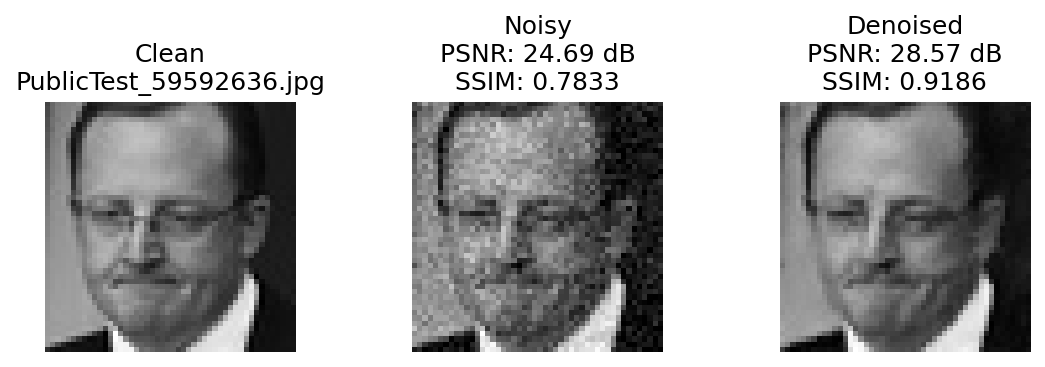

✅ Sample 9 displayed and saved: /content/drive/MyDrive/denoising_samples_eval/sample_9_PublicTest_59592636.jpg.png
  Clean-Noisy: PSNR: 24.69 dB | SSIM: 0.7833
  Clean-Denoised: PSNR: 28.57 dB | SSIM: 0.9186


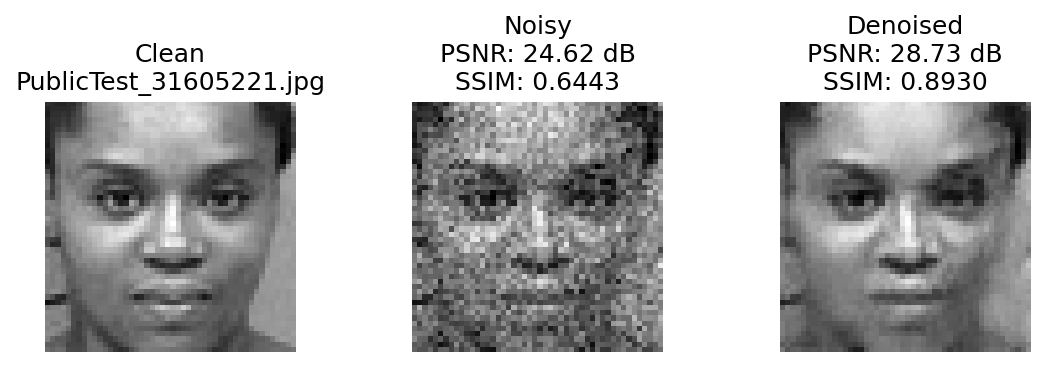

✅ Sample 10 displayed and saved: /content/drive/MyDrive/denoising_samples_eval/sample_10_PublicTest_31605221.jpg.png
  Clean-Noisy: PSNR: 24.62 dB | SSIM: 0.6443
  Clean-Denoised: PSNR: 28.73 dB | SSIM: 0.8930


In [15]:
# Sample evaluation for 10 random images - UPDATED: Clean, Noisy, Denoised with metrics for clean-noisy and clean-denoised
num_samples = 10
output_dir = '/content/drive/MyDrive/denoising_samples_eval'
os.makedirs(output_dir, exist_ok=True)

print(f"\n🎲 Generating {num_samples} random samples (Clean + Noisy + Denoised with metrics)...")
with torch.no_grad():
    test_samples = random.sample(list(test_dataset), min(num_samples, len(test_dataset)))
    sample_psnr_clean_denoised = []
    sample_ssim_clean_denoised = []
    for idx, (noisy, clean, noisy_path) in enumerate(test_samples):
        noisy, clean = noisy.unsqueeze(0).to(device), clean.unsqueeze(0).to(device)
        denoised = model(noisy)

        # Convert to numpy
        noisy_np = np.clip(noisy.cpu().numpy()[0, 0], 0, 1).astype(np.float32)
        clean_np = np.clip(clean.cpu().numpy()[0, 0], 0, 1).astype(np.float32)
        denoised_np = np.clip(denoised.cpu().numpy()[0, 0], 0, 1).astype(np.float32)

        # Metrics
        psnr_nc = peak_signal_noise_ratio(clean_np, noisy_np, data_range=1.0)
        ssim_nc = structural_similarity(clean_np, noisy_np, data_range=1.0, win_size=7)
        psnr_cd = peak_signal_noise_ratio(clean_np, denoised_np, data_range=1.0)
        ssim_cd = structural_similarity(clean_np, denoised_np, data_range=1.0, win_size=7)
        sample_psnr_clean_denoised.append(psnr_cd)
        sample_ssim_clean_denoised.append(ssim_cd)

        # Plot: Clean, Noisy, Denoised
        fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))
        axes[0].imshow(clean_np, cmap='gray')
        axes[0].set_title(f'Clean\n{os.path.basename(noisy_path)}')
        axes[0].axis('off')
        axes[1].imshow(noisy_np, cmap='gray')
        axes[1].set_title(f'Noisy\nPSNR: {psnr_nc:.2f} dB\nSSIM: {ssim_nc:.4f}')
        axes[1].axis('off')
        axes[2].imshow(denoised_np, cmap='gray')
        axes[2].set_title(f'Denoised\nPSNR: {psnr_cd:.2f} dB\nSSIM: {ssim_cd:.4f}')
        axes[2].axis('off')
        plt.tight_layout()

        # Save plot
        sample_path = os.path.join(output_dir, f'sample_{idx+1}_{os.path.basename(noisy_path)}.png')
        plt.savefig(sample_path, dpi=150, bbox_inches='tight')
        plt.close(fig)

        # Display in Colab
        display(Image(filename=sample_path))

        print(f"✅ Sample {idx+1} displayed and saved: {sample_path}")
        print(f"  Clean-Noisy: PSNR: {psnr_nc:.2f} dB | SSIM: {ssim_nc:.4f}")
        print(f"  Clean-Denoised: PSNR: {psnr_cd:.2f} dB | SSIM: {ssim_cd:.4f}")